In [31]:
import nltk
import os
import re
import IPython
from nltk.tag import SequentialBackoffTagger
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from nltk import word_tokenize, sent_tokenize

In [11]:
def ie_process(sentence):
    """ Tokenizes and Tags each sentence.
    
    sentence: inputs a sentence.
    
    Returns: a tagged sentence.
    """
    tokenized_sentence = re.findall(r"(\b\w*[\.]?\w+\b|[\(\)\+\*\-\/])", sentence)
    tagged_sentence = (tokenized_sentence)
    return tagged_sentence

In [12]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 13 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 10, 10)
    cf.print_to_file('tmp_tree_output.ps')
    cf.destroy()
    os.system('convert tmp_tree_output.ps tmp_tree_output.png')
    IPython.core.display.display(IPython.core.display.Image(filename='tmp_tree_output.png'))
    os.system('rm tmp_tree_output.ps tmp_tree_output.png')

In [117]:
def math_chunk(tagged_sentence):
    """Breaks a sentence into a chunk of Operators, Operands and Mathematical Expressions
    
    tagged_sentence: inputs pos tagged sentence
    
    Returns: a sentence chunked into a set of Operators, Operands and Mathematical Expressions
    """
    # TODO: Grammar can be written better with Cascaded Chunkers     
    grammar = r"""
    ME:       {<CD><OPERATOR|OPERATIVE_ADJECTIVE><CD>}
              {<ME><OPERATOR|OPERATIVE_ADJECTIVE><CD>}
              {<CD><OPERATOR|OPERATIVE_ADJECTIVE><ME>}
              {<OPERATOR|OPERATIVE_ADJECTIVE><ME><CD>}    
    """
    cp = nltk.RegexpParser(grammar, loop=3, trace=1)
    result = cp.parse(tagged_sentence)
    print(result)
    jupyter_draw_nltk_tree(result)
    return result

## Analyzing parse tree of chunks

(S
  What/WP
  is/VBZ
  2/CD
  +/NN
  344/CD
  +/NN
  34/CD
  added/OPERATIVE_ADJECTIVE
  by/IN
  2/CD)


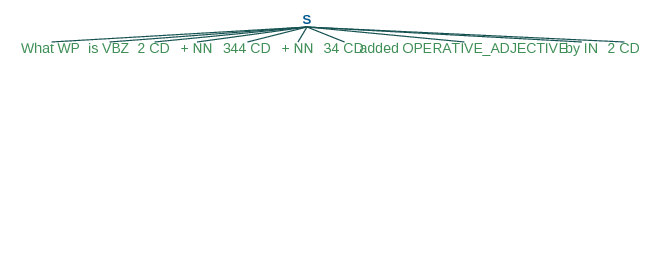

In [105]:
chunked_result = math_chunk(ie_process("What is 2+344+34 added by 2?"))

(S What/WP is/VBZ 2/CD +/NN 2/CD +/NN 4/CD mutilplied/VBN by/IN 4/CD)


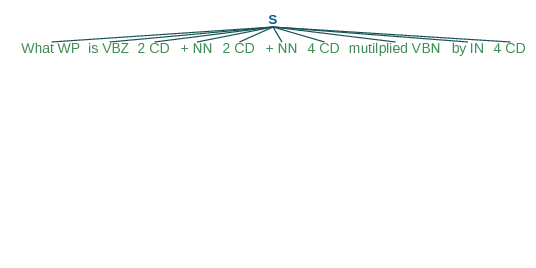

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpy7_5whrf.png'

Tree('S', [('What', 'WP'), ('is', 'VBZ'), ('2', 'CD'), ('+', 'NN'), ('2', 'CD'), ('+', 'NN'), ('4', 'CD'), ('mutilplied', 'VBN'), ('by', 'IN'), ('4', 'CD')])

In [106]:
math_chunk(ie_process("What is 2 + 2 + 4 mutilplied by 4?"))

In [107]:
operators = {
    "mul": "*",
    "multiply": "*",
    "multiplied": "*",
    "product": "*",
    "add": "*",
    "plus": "+",
    "added": "+",
    "+": "+",
    "-": "-",
    "*": "*",
    "/": "/",
    "sum": "+",
    "minus": "-",
    "subtract": "",
    "subtracted": "-",
    "sub": "-",
    "division": "/",
    "divided": "/",
    "greater": ">",
    "lesser": "<",
    "higher": ">",
    "lowest": "<",
    ">": ">",
    "<": "<"
}

In [108]:
def process_math_chunk(chunked_sentences):
    """Processes a mathematical chunked sentence and returns an mathematical expression.
    
    chunked_sentence: inputs a math chunked sentence.
    
    Returns: a mathematical expression
    """
    expression = ""
    for chunk in chunked_sentences:
        if isinstance(chunk, nltk.tree.Tree):
            if chunk.label() == 'OPERATOR':
                intent = list(set([j for i in chunk for j in i]) & set(operators.keys()))[0]
                expression += operators[intent]
            if chunk.label() == 'ME':
                expression = "(" + process_math_chunk(chunk) + ")"
            if chunk.label() == 'OPERAND':
                operand = chunk[0][0]
                expression += operand
    return expression
                
                    

In [109]:
func_map = {
    "+": lambda x, y: x + y,
    "-": lambda x, y: x - y,
    "*": lambda x, y: x * y,
    "/": lambda x, y: x / y,
    "^": lambda x, y: x ^ y
}

In [110]:
def infix2postfix(expression):
    """Converts an Infix expression to a Postfix expression
    
    expression: input an infix expression
    
    Returns: an postfix expression
    """
    print("Printing expression")
    print(expression)
    stack = []
    stack.append('e');
    number_str=''
    operators = ['^', '*', '/', '+', '-']
    operator_precedence = {
        "^": 4,
        "*": 3,
        "/": 3,
        "+": 2,
        "-": 2,
        "(": 0,
        ")": 0,
        'e': 0
    }
    for token in expression:
        if not token.isdigit() and number_str:
            yield number_str
            number_str = ""
        
        if token in operators:
            while True:
                if operator_precedence[token] > operator_precedence[stack[-1]]:
                    stack.append(token)
                    break
                else:
                    yield stack.pop()
                    
        elif token.isdigit():
            number_str += token
                    
        elif token == "(":
            stack.append(token)
            
        elif token == ")":
            while True:
                ch = stack.pop()
                if ch == "(":
                    break
                else:
                    yield ch
    if number_str:
        yield number_str
        
    for s in reversed(stack[1:]):
        yield s

In [111]:
def postfix_calculate(iterator):
    """Performs calculation over postfix expression.
    
    iterator: inputs an postfix iterator
    
    Returns: a calculated value of the postfix expression
    """
    stack = []
    for ch in iterator:
        try:
            print(ch)
            stack.append(float(ch))
        except ValueError:
            func = func_map[ch]
            y = stack.pop()
            x = stack.pop()
            stack.append(func(x, y))
    return stack[0]

In [112]:
reflections = {
    "true" : "Yes",
    "false": "No"
}

answerable = [
    [r'What is 2+3?', 
     ['Hey, {0} is {1}', "Wohoo, {0} is {1}. Am I right?"],
     ["Oops, that didnt. But you can ask me what is 232+344 multiplied by 7?. And I can be awesome :wink:"]],
    
    [r'Is (.*) (?:greater than|lesser than|>|<|>=|<=) (.*)',
     ['{2}, {0} is greater than {1}']],
    
    [r'Calculate (.*)',
     ['Calculated {0} to be as {1}']],
    
    [r'How much is (.*)',
     ['{0} is {1}']]
]

In [113]:
def reflect(fragment):
    print("Printing fragment")
    print(fragment)
    tokens = fragment.lower().split()
    for i, token in enumerate(tokens):
        if token in reflections:
            tokens[i] = reflections[token]
    return ' '.join(tokens)

def answer(question):
    """Responds to the question asked
    question: inputs a nlp statement
    
    Returns: a calculated value in response to the input statement
    """
    sentences = sent_tokenize(question)
    print(sentences)
    results = []
    for sentence in sentences:
        tagged_sentence = ie_process(sentence)
        chunked_sentence = math_chunk(tagged_sentence)
        processed_chunk = process_math_chunk(chunked_sentence)
        if len(set(['>', '<', '>=', '<=', '==', '!=']) & set(list(processed_chunk))) == 0:
            eval_result = str(postfix_calculate(infix2postfix(processed_chunk)))
        else:
            eval_result = str(eval(processed_chunk))
        for pattern, responses in answerable:
            match = re.match(pattern, sentence.rstrip('?'))
            if match:
                response_groups = list(match.groups())
                response_groups.append(eval_result)
                results.append(responses[0].format(*[reflect(group) for group in response_groups]))
        if len(results) < 1:
            results.append(eval_result)
    return results

(S What/WP is/VBZ 2/CD added/OPERATIVE_ADJECTIVE by/IN 4/CD)


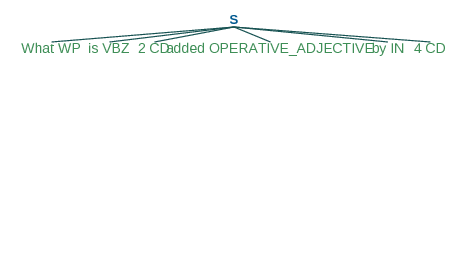

Printing expression



IndexError: list index out of range

In [114]:
postfix_calculate(infix2postfix(process_math_chunk(math_chunk(ie_process(sent_tokenize("What is 2 added by 4?")[0])))))

In [ ]:
eval(process_math_chunk(math_chunk(ie_process(sent_tokenize("What is 2 added by 4?")[0]))))

In [ ]:
' '.join(answer("What is 2+2?"))

In [ ]:
math_chunk(ie_process("What is 2 added by 2"))

In [ ]:
def extract_features(question):
    tokenized_question = word_tokenize(question)
    start_of_question = tokenized_question[0]
    presence_of_boolean_op = len(set(['true', 'false']).intersection(tokenized_question)) > 0
    presence_of_comparison_op = len(set(['greater', 'lesser']).intersection(tokenized_question)) > 0
    return {
        "start_of_question": start_of_question,
        "presence_of_boolean_op": presence_of_boolean_op,
        "presence_of_comparison_op": presence_of_comparison_op
    }

In [ ]:
featureset = [];
for file in ['compute', 'boolean', 'comparison']: 
    with open(file) as fp:
        featureset += [(extract_features(line), file) for line in fp]

len(featureset)

In [ ]:
import random

random.shuffle(featureset)

trainset, testset = featureset[15:], featureset[:15]

classifier = nltk.NaiveBayesClassifier.train(trainset)

classifier.classify(extract_features("Is 43+24 greater than 22?"))

nltk.classify.accuracy(classifier, testset)

In [ ]:
if 32*443 > 32*2:
    print("hell0")

In [ ]:
nltk.data.show_cfg('grammars/book_grammars/sql0.fcfg')

In [ ]:
nltk.parse_cfg()

In [ ]:
import nltk

In [ ]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant'| 'pajamas'
V -> 'shot'
P -> 'in'
""")

In [ ]:
grammar.start()

In [ ]:
parser = nltk.ChartParser(grammar)
for tree in parser.parse(word_tokenize("I shot an elephant in my pajamas")):
    print(tree)

In [ ]:
nltk.pos_tag(word_tokenize("All the trains from chennai central to Bangalore cant"))

In [ ]:
nltk.pos_tag(word_tokenize('all trains from chennai,bangalore'))

In [ ]:
read_expr = nltk.sem.Expression.fromstring

In [ ]:
expression = read_expr('walk("angus")', type_check=True)

In [ ]:
expression.argument

In [ ]:
expression.argument.type

In [ ]:
answer('What is 2+5+3 multiplied by 5?')

In [ ]:
from nltk import load_parser

In [ ]:
cp = load_parser('test1.fcfg', trace=3)

In [ ]:
operative_adjectives = [
    'added',
    'substracted',
    'multiplied',
    'divided'
]

In [ ]:
class LocationBackedPOSTagger(SequentialBackoffTagger):
    
    def __init__(self, *args, **kwargs):
        SequentialBackoffTagger.__init__(self, *args, **kwargs)
        self.operator_set = list(operators.keys())
        self.operative_adjectives = ['added', 'substracted', 'multiplied', 'divided']
        
    def choose_tag(self, tokens, index, history):
        tag = None
        if tokens[index] in self.operator_set:
            tag = 'OPERATOR'
        if tokens[index] in self.operative_adjectives:
            tag = 'OPERATIVE_ADJECTIVE'
        else:
            tag = nltk.pos_tag([tokens[index]])[0][1]
        return tag

In [ ]:
operators = {
    'plus': '+',
    'add': '+',
    'sum': '+',
    '+': '+',
    'difference': '-',
    'minus': '-',
    '-': '-',
    'product': '*',
    'multiply': '*',
    '*': '*',
    'divide': '/',
    'division': '/',
    '/': '/'
}

In [ ]:
math_chunk(ie_process('What is 2 plus 2 added by 4?'))

In [ ]:
tagger = LocationBackedPOSTagger()

# Testing the working of LocationBackedPOSTagger
tagged_words = tagger.tag(word_tokenize('What is 2 plus 2 added by 4?'))

tagged_words

In [ ]:
list(operators.keys())

In [118]:
def ie_process(sentence):
    """ Tokenizes and Tags each sentence.
    
    sentence: inputs a sentence.
    
    Returns: a tagged sentence.
    """
    tokenized_sentence = re.findall(r"(\b\w*[\.]?\w+\b|[\(\)\+\*\-\/])", sentence)
    tagged_sentence = tagger.tag(tokenized_sentence)
    return tagged_sentence

In [119]:
tagged_words = ie_process('What is 2 added by 2?')

(S What/WP is/VBZ 2/CD added/OPERATIVE_ADJECTIVE by/IN 2/CD)


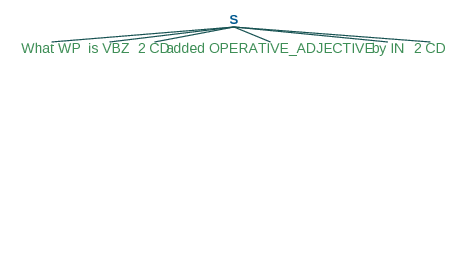

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp5np2wj2c.png'

Tree('S', [('What', 'WP'), ('is', 'VBZ'), ('2', 'CD'), ('added', 'OPERATIVE_ADJECTIVE'), ('by', 'IN'), ('2', 'CD')])

In [116]:
math_chunk(tagged_words)

In [ ]:
tokens = list(set([tag for word, tag in tagged_words]) & set(['CD', 'OPERATIVE_ADJECTIVE', 'OPERATOR']))

In [ ]:
[jupyter_draw_nltk_tree(tree) for tree in list(cp.parse(tokens))]